# Stock Price Prediction Using Machine Learning
### Project Overview
This project is part of my final submission for the Master of Science (MSc) degree in Computer Science. The primary objective of this project is to predict stock prices using machine learning models. By leveraging historical market data and employing various algorithms, the goal is to provide insights and forecasts that could be beneficial for investors and financial analysts.

## Importing Libraries

In this cell, we import the essential libraries required for our stock price prediction project

The `%matplotlib inline` command is used to display Matplotlib plots directly within the Jupyter Notebook, making it easier to visualize the data and results.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasRegressor
from ta.trend import cci,MACD
from ta.volume import AccDistIndexIndicator
from ta.volatility import BollingerBands,average_true_range
from ta.momentum import rsi,StochasticOscillator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input


## Data Collection and Preparation

This cell is responsible for loading the historical NASDAQ Composite Index data, which has been manually downloaded from Bloomberg and saved locally in the `Data` directory. The data covers the period from 2014 through 2023, providing a decade of financial information for analysis
.


## About NASDAQ Composite
he Nasdaq Composite® is a unique exchange-based index encompassing all companies listed on the Nasdaq Stock Market®. It distinguishes itself by not imposing restrictions related to size, sector classification, liquidity, geography, or float. Instead, the sole requirement for inclusion is a Nasdaq listing, resulting in an impressive portfolio of approximately 3,500 stocks that span a diverse range of countries, sectors, and sizes, and boasts a total market cap of $22.4T.


In [2]:
# Define the directory and file name
directory = 'Data'
file_name = 'XCMP.xlsx'

# Combine the directory and file name into a full path
file_path = os.path.join(directory, file_name)

# Read the Excel file into a DataFrame
XCMP_data = pd.read_excel(file_path)

# Convert to datetime if not already
XCMP_data['Date'] = pd.to_datetime(XCMP_data['Date'])  

# Set 'Date' column as the index
XCMP_data.set_index('Date', inplace=True)       


# Exploring and Understanding the Dataset

Before proceeding with data cleaning and preparation, it's essential to understand the structure and content of our NASDAQ Composite Index dataset. This section uses Pandas functions to:

- **View the first few rows** of the data to get an initial overview of the available columns and their values.
- **Check the data types and non-null counts** to ensure all columns have the expected types and to identify any missing values.
- **Identify missing data** by calculating the number of null values in each column.
- **List the column names** to understand what parameters are included in the dataset.
- **Obtain basic statistical insights** such as mean, standard deviation, minimum, and maximum values for numerical columns to assess the data distribution.

These steps will provide a comprehensive understanding of the dataset, allowing us to make informed decisions about necessary data cleaning and preparation.


In [3]:
# Display the first few rows of the data to get an overview
print("First 5 rows of the dataset:")
print(XCMP_data.head())
print("\n" + "="*50 + "\n")  # Separator

# Get information about the dataset, including data types and non-null values
print("Dataset Information:")
print(XCMP_data.info())
print("\n" + "="*50 + "\n")  # Separator

# Check for any missing values in the dataset
print("Missing values in each column:")
print(XCMP_data.isnull().sum())
print("\n" + "="*50 + "\n")  # Separator

# Display the column names to see what parameters are available
print("Column names in the dataset:")
print(XCMP_data.columns)
print("\n" + "="*50 + "\n")  # Separator

# Get basic statistical details of the dataset
print("Statistical summary of numerical columns:")
print(XCMP_data.describe())


First 5 rows of the dataset:
               Open     High      Low     Volume  Adj Close
Date                                                       
2014-01-02  4563.58  4564.60  4532.60  446910020    4544.97
2014-01-03  4551.02  4555.85  4525.14  396555891    4532.75
2014-01-06  4538.40  4541.41  4501.88  537649195    4512.78
2014-01-07  4529.15  4561.64  4526.86  525550217    4556.15
2014-01-08  4557.42  4576.59  4547.24  560593013    4569.85


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Volume     2516 non-null   int64  
 4   Adj Close  2516 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 117.9 KB
None


Missing values in each column:
Open         0
High         0
Low 

### Dataset Columns Explanation

- **Date**: The specific day the data was recorded, formatted as YYYY-MM-DD.

- **Open**: The price of the stock at the beginning of the trading day.

- **High**: The highest price at which the stock traded during the trading day.

- **Low**: The lowest price at which the stock traded during the trading day.

- **Volume**: The total number of shares traded during the trading day, indicating the overall activity level of the stock.

- **Adj Close**: The stock's closing price after adjustments for all applicable splits and dividend distributions. This value is used to analyze historical stock returns and to compare the performance of different stocks.


# NASDAQ Composite Total Return Prices (2014 - 2023)

The following plot represents the **NASDAQ Composite Total Return Prices** from 2014 to 2024. The data includes the adjusted closing prices, which take into account corporate actions such as dividends and stock splits. The chart highlights the trend in NASDAQ's performance over this period, showcasing the upward movement as well as periods of volatility.

- **X-axis**: Date (Yearly from 2014 to 2024)
- **Y-axis**: Closing Price in USD
- **Line**: NASDAQ Adjusted Closing Prices

This visual representation helps in understanding how the NASDAQ Composite Index performed over time, reflecting market trends, growth, and periods of correction.


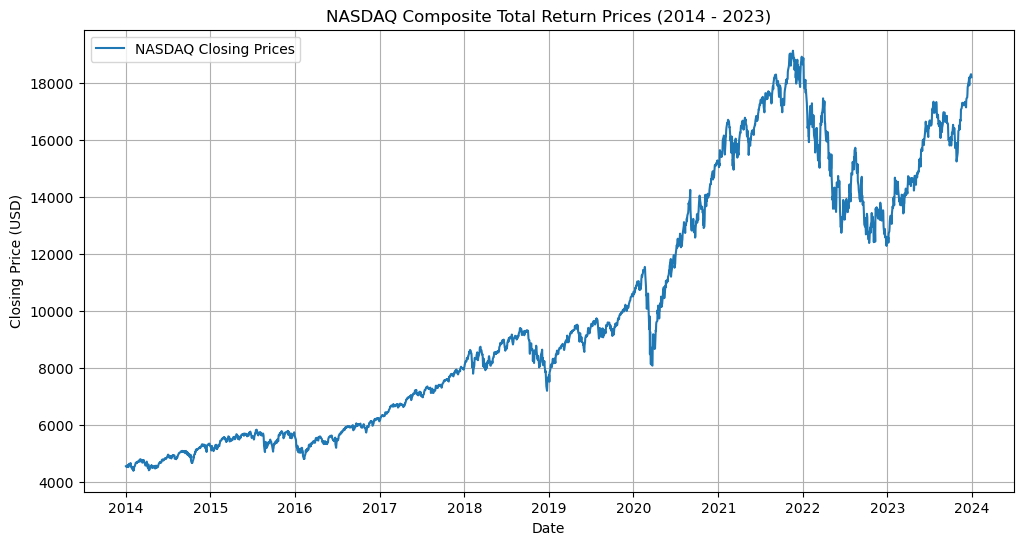

In [4]:
# Plotting the Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(XCMP_data.index, XCMP_data['Adj Close'], label='NASDAQ Closing Prices')
plt.title('NASDAQ Composite Total Return Prices (2014 - 2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Technical Indicators Overview

Below is a list of various technical indicators integrated with moving averages to predict market tre
:

- **SMA (Simple Moving Average)**
  - Calculates the average of a selected range of prices, typically closing prices, over a defined number of periods, smoothing out price data.

- **MA (Moving Average, including Exponentially Weighted)**
  - Averages prices over a period, with variations like the Exponential Moving Average (EMA) that gives more weight to recent prices, making it more responsive to new information.

- **RSI (Relative Strength Index)**
  - A momentum oscillator that measures the speed and change of price movements, with levels identified at 70 (overbought) and 30 (oversold).

- **Stochastic Oscillator (Stochastic K)**
  - Compares a specific closing price of a security to its price range over a certain period, helping identify momentum changes.

- **MACD (Moving Average Convergence Divergence)**
  - A trend-following momentum indicator showing the relationship between two moving averages of a security's prices.

- **CCI (Commodity Channel Index)**
  - An oscillator that measures the variation of a security's price from its statistical mean, highlighting periods of overbought or oversold conditions.

- **ATR (Average True Range)**
  - Measures market volatility by decomposing the entire range of an asset price for that period.

- **Acc/Dist (Accumulation/Distribution Line)**
  - Measures the cumulative flow of money into and out of a security, indicating whether the stock is being accumulated or distributed.

- **Bollinger Bands**
  - Uses a moving average with two trading bands above and below it. Unlike a simple moving average, the bands widen during periods ofherawer.
during less volatile periods.

Each indicator can help traders understand different aspects of market behavior and can be used in combination to make more informed trading decisions.


In [5]:
def add_derived_indicators (df, ma_periods, ema_periods, momentum_periods, return_periods):
    """
    Enhance the dataframe with technical indicators.
    
    Parameters:
    df (DataFrame): Original dataframe with stock data.
    ma_periods (list): List of periods for calculating moving averages.
    ema_periods (list): List of periods for calculating exponential moving averages.
    momentum_periods (list): List of periods for calculating momentum.
    return_periods (list): List of periods for calculating returns.
    
    Returns:
    DataFrame: Enhanced dataframe with new technical indicators.
    """
    
    # Moving averages
    for period in ma_periods: 
        
        df[f'MA_{period}'] = df['Adj Close'].rolling(period).mean()

    # Exponential moving averages
    for period in ema_periods:
        df[f'EMA_{period}'] = df['Adj Close'].ewm(span=period, adjust=False).mean()

    # Moving Average Convergence Divergence
    
    #calculating the indicator
    macd_indicator = MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)

    # Addind data to the DataFrame
    df['MACD'] = macd_indicator.macd()
    df['MACD_signal'] = macd_indicator.macd_signal()
    df['MACD_diff'] = macd_indicator.macd_diff()    

    # Calculate the RSI for the closing prices
    df['RSI'] = rsi(df['Adj Close'], window=14)
    
    # Calculate the Stochastic %K
    # The window parameter defines the lookback period for calculating %K,
    # and smooth_window parameter is used for smoothing the %K line.
    stochastic_oscillator = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Adj Close'], window=14, smooth_window=3)

    # Add the %K line to the DataFrame   
    df['stochastic_k'] = stochastic_oscillator.stoch()
    
    # Commodity Channel Index (CCI)
    df['CCI'] = cci(df['High'], df['Low'], df['Adj Close'], window=20)
    
    # Average True Range (ATR)
    df['ATR'] = average_true_range(df['High'], df['Low'], df['Adj Close'], window=14)
    
    # Calculate the Accumulation/Distribution Index
    adi = AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Adj Close'], volume=df['Volume'])
    df['A/D Index'] = adi.acc_dist_index()
    
    # Returns for specified periods
    for period in return_periods:
        df[f'Return_{period}d'] = df['Adj Close'].pct_change(period)
    
    # Momentum for specified periods
    for period in momentum_periods:
        df[f'Momentum_{period}d'] = df['Adj Close'].diff(period)

    # Initialize Bollinger Bands Indicator with window size (usually 20) and standard deviation multiplier (usually 2)
    bb_indicator = BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
    
    # Calculate the Bollinger Bands
    df['Bollinger High'] = bb_indicator.bollinger_hband()  # Upper Band
    df['Bollinger Low'] = bb_indicator.bollinger_lband()   # Lower Band
    df['Bollinger SMA'] = bb_indicator.bollinger_mavg()    # Moving Average (SMA)

    return df




In [6]:
ma_periods = [10, 20, 50]
ema_periods = [10, 20, 50]
momentum_periods = [1, 5, 10]
return_periods = [1, 5, 10]
XCMP_data_derived_indicators = add_derived_indicators(XCMP_data, ma_periods, ema_periods, momentum_periods, return_periods)

In [7]:
print(XCMP_data_derived_indicators.tail())

                Open      High       Low      Volume  Adj Close      MA_10  \
Date                                                                         
2023-12-22  18199.23  18248.97  18103.35   881138226   18183.22  17937.366   
2023-12-26  18226.55  18314.47  18220.95   880275147   18282.20  18015.690   
2023-12-27  18302.18  18331.79  18256.10  1072083217   18313.72  18084.866   
2023-12-28  18366.93  18376.60  18300.38   909092166   18309.97  18129.333   
2023-12-29  18315.05  18329.86  18140.59  1042297151   18208.50  18160.175   

                 MA_20       MA_50        EMA_10        EMA_20  ...  \
Date                                                            ...   
2023-12-22  17613.3760  16855.9422  17931.368493  17662.015872  ...   
2023-12-26  17664.4810  16896.9474  17995.156040  17721.081027  ...   
2023-12-27  17714.6875  16934.6902  18053.076760  17777.522834  ...   
2023-12-28  17766.0655  16973.1870  18099.784622  17828.232088  ...   
2023-12-29  17814.1715  170

## Adding External Indicators to the DataFrame

This function adds external economic indicators to the stock data. The external indicators used in this case are:

- **USDX (U.S. Dollar Index)**: Measures the value of the U.S. dollar relative to a basket of foreign currencies.
- **EFFR (Effective Federal Funds Rate)**: The interest rate at which depository institutions trade federal funds overnight.
- **UNRATE (Unemployment Rate)**: The percentage of the labor force that is unemployed.

The function is generic and can be extended to load and integrate additional external data as needed.


In [8]:
def add_external_indicators (df, file_paths):
    """
    Enhance the dataframe with external indicators.
    
    Parameters:
    df (DataFrame): Original dataframe with stock data.
    
    Returns:
    DataFrame: Enhanced dataframe with new external indicators.
    """

    # Iterate over each file path in the list
    for file_path in file_paths:
        # Load the current file into a DataFrame
        new_df = pd.read_excel(file_path)
        
        # Ensure the 'Date' column is set as index if it hasn't been already
        if 'Date' not in new_df.columns:
            print(f"No 'Date' column in {file_path}. Skipping this file.")
            continue
        
        new_df.set_index('Date', inplace=True)
        
        # Merge the new DataFrame into the base DataFrame
        df = df.join(new_df, how='left', rsuffix='_new')
            
    return df

In [9]:
XCMP_data_all_indicators = add_external_indicators(XCMP_data_derived_indicators,['Data/EFFR.xlsx','Data/DXY.xlsx','Data/UNRATE.xlsx'])

## Defining the Target Column for Stock Price Prediction

The Target column in a stock price prediction model is vital for indicating potential price movements. It is based on the percentage change in the stock price from one day to the next:

- **+1**: Assigned if the stock price rises by more than 0.5% from the previous day, indicating a likely increase.
- **-1**: Assigned if the stock price falls by more than 0.5% from the previous day, indicating a likely decrease.
- **0**: Assigned if the stock price change is within +/- 0.5%, indicating little or no change.

This classification helps in simplifying the prediction into actionable insights, indicating whether the stock is expected to rise, fall, or remain relatively stable.


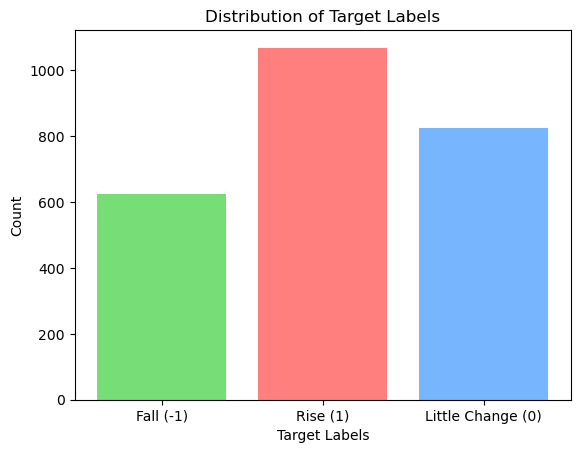

In [10]:
# Directly create the Target column based on percentage price changes from the previous day
XCMP_data_all_indicators['Target'] = XCMP_data_all_indicators['Adj Close'].pct_change().apply(lambda x: 1 if x > 0.005 else (-1 if x < -0.005 else 0))

# Count the occurrences of each Target value
target_counts = XCMP_data_all_indicators['Target'].value_counts()

# Plotting the results in a bar chart
plt.bar(target_counts.index, target_counts.values, color=['#FF7F7F', '#77B5FE', '#77DD77'])
plt.xlabel('Target Labels')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.xticks(ticks=target_counts.index, labels=['Rise (1)', 'Little Change (0)', 'Fall (-1)'])
plt.show()


## Removing Missing Values and Dataset Information

The next code removes rows with missing values from the `XCMP_data_all_indicators` DataFrame using `dropna(inplace=True)`, and then prints the first 5 rows to verify the removal. It also provides dataset information (data types and non-null values) via `info()`. A separator is added for clearer output presentation.



In [11]:
# Display the first few rows of the data to get an overview
print("First 5 rows of the dataset:")
print(XCMP_data_all_indicators.head())
print("\n" + "="*50 + "\n")  # Separator

# Get information about the dataset, including data types and non-null values
print("Dataset Information:")
print(XCMP_data_all_indicators.info())
print("\n" + "="*50 + "\n")  # Separator

# Check for any missing values in the dataset
print("Missing values in each column:")
print(XCMP_data_all_indicators.isnull().sum())
print("\n" + "="*50 + "\n")  # Separator

# Display the column names to see what parameters are available
print("Column names in the dataset:")
print(XCMP_data_all_indicators.columns)
print("\n" + "="*50 + "\n")  # Separator

# Get basic statistical details of the dataset
print("Statistical summary of numerical columns:")
print(XCMP_data_all_indicators.describe())


First 5 rows of the dataset:
               Open     High      Low     Volume  Adj Close  MA_10  MA_20  \
Date                                                                        
2014-01-02  4563.58  4564.60  4532.60  446910020    4544.97    NaN    NaN   
2014-01-03  4551.02  4555.85  4525.14  396555891    4532.75    NaN    NaN   
2014-01-06  4538.40  4541.41  4501.88  537649195    4512.78    NaN    NaN   
2014-01-07  4529.15  4561.64  4526.86  525550217    4556.15    NaN    NaN   
2014-01-08  4557.42  4576.59  4547.24  560593013    4569.85    NaN    NaN   

            MA_50       EMA_10       EMA_20  ...  Momentum_1d  Momentum_5d  \
Date                                         ...                             
2014-01-02    NaN  4544.970000  4544.970000  ...          NaN          NaN   
2014-01-03    NaN  4542.748182  4543.806190  ...       -12.22          NaN   
2014-01-06    NaN  4537.299421  4540.851315  ...       -19.97          NaN   
2014-01-07    NaN  4540.726799  4542.3083

In [12]:
XCMP_data_all_indicators.dropna(inplace=True)
print(XCMP_data_all_indicators.head())

               Open     High      Low     Volume  Adj Close     MA_10  \
Date                                                                    
2014-03-14  4673.88  4697.95  4664.52  530243493    4668.32  4743.580   
2014-03-17  4700.20  4729.96  4698.87  468683676    4706.50  4744.067   
2014-03-18  4713.46  4766.72  4711.14  468700809    4765.24  4742.218   
2014-03-19  4763.22  4766.35  4710.52  492518340    4736.99  4736.847   
2014-03-20  4726.44  4761.21  4714.81  446756648    4749.86  4733.374   

                MA_20      MA_50       EMA_10       EMA_20  ...  Momentum_1d  \
Date                                                        ...                
2014-03-14  4722.7030  4615.9400  4722.832571  4703.404725  ...       -16.48   
2014-03-17  4724.9380  4619.1706  4719.863013  4703.699513  ...        38.18   
2014-03-18  4728.4325  4623.8204  4728.113374  4709.560512  ...        58.74   
2014-03-19  4732.4250  4628.3046  4729.727306  4712.172844  ...       -28.25   
2014-03-

## Standardize Numeric Columns in DataFrame

This code standardizes all numeric columns, excluding the 'Date' column, within a DataFrame.


In [13]:
# Initializing the StandardScaler
scaler = StandardScaler()

# Selecting all columns except 'Date' for standardization
columns_to_scale = XCMP_data_all_indicators.columns.difference(['Date','Target'])

# Standardizing the selected columns
XCMP_data_all_indicators[columns_to_scale] = scaler.fit_transform(XCMP_data_all_indicators[columns_to_scale])

In [14]:
# Get information about the dataset, including data types and non-null values
print("Dataset Information:")
print(XCMP_data_all_indicators.describe())
print("\n" + "="*50 + "\n")  # Separator

Dataset Information:
               Open         High          Low        Volume     Adj Close  \
count  2.467000e+03  2467.000000  2467.000000  2.467000e+03  2.467000e+03   
mean  -2.764982e-16     0.000000     0.000000  1.382491e-16 -2.764982e-16   
std    1.000203e+00     1.000203     1.000203  1.000203e+00  1.000203e+00   
min   -1.306444e+00    -1.302511    -1.318811 -1.526793e+00 -1.310753e+00   
25%   -9.690978e-01    -0.972256    -0.968342 -7.055635e-01 -9.693563e-01   
50%   -2.679260e-01    -0.263705    -0.262104 -3.780797e-01 -2.635194e-01   
75%    9.157659e-01     0.918197     0.909533  5.881416e-01  9.074260e-01   
max    2.069592e+00     2.061682     2.077976  1.033283e+01  2.052111e+00   

              MA_10        MA_20         MA_50        EMA_10        EMA_20  \
count  2.467000e+03  2467.000000  2.467000e+03  2.467000e+03  2.467000e+03   
mean  -9.216606e-17     0.000000  9.216606e-17  1.843321e-16  2.764982e-16   
std    1.000203e+00     1.000203  1.000203e+00  1.0

## Correlation Matrix and Heatmap Visualization

This code calculates the correlation matrix for all numerical columns in the `XCMP_data_all_indicators` DataFrame and visualizes it using a heatmap. The heatmap provides a color-coded representation of the correlations between the variables, with annotations showing the exact correlation values. The size and color map of the heatmap are customized for clarity.


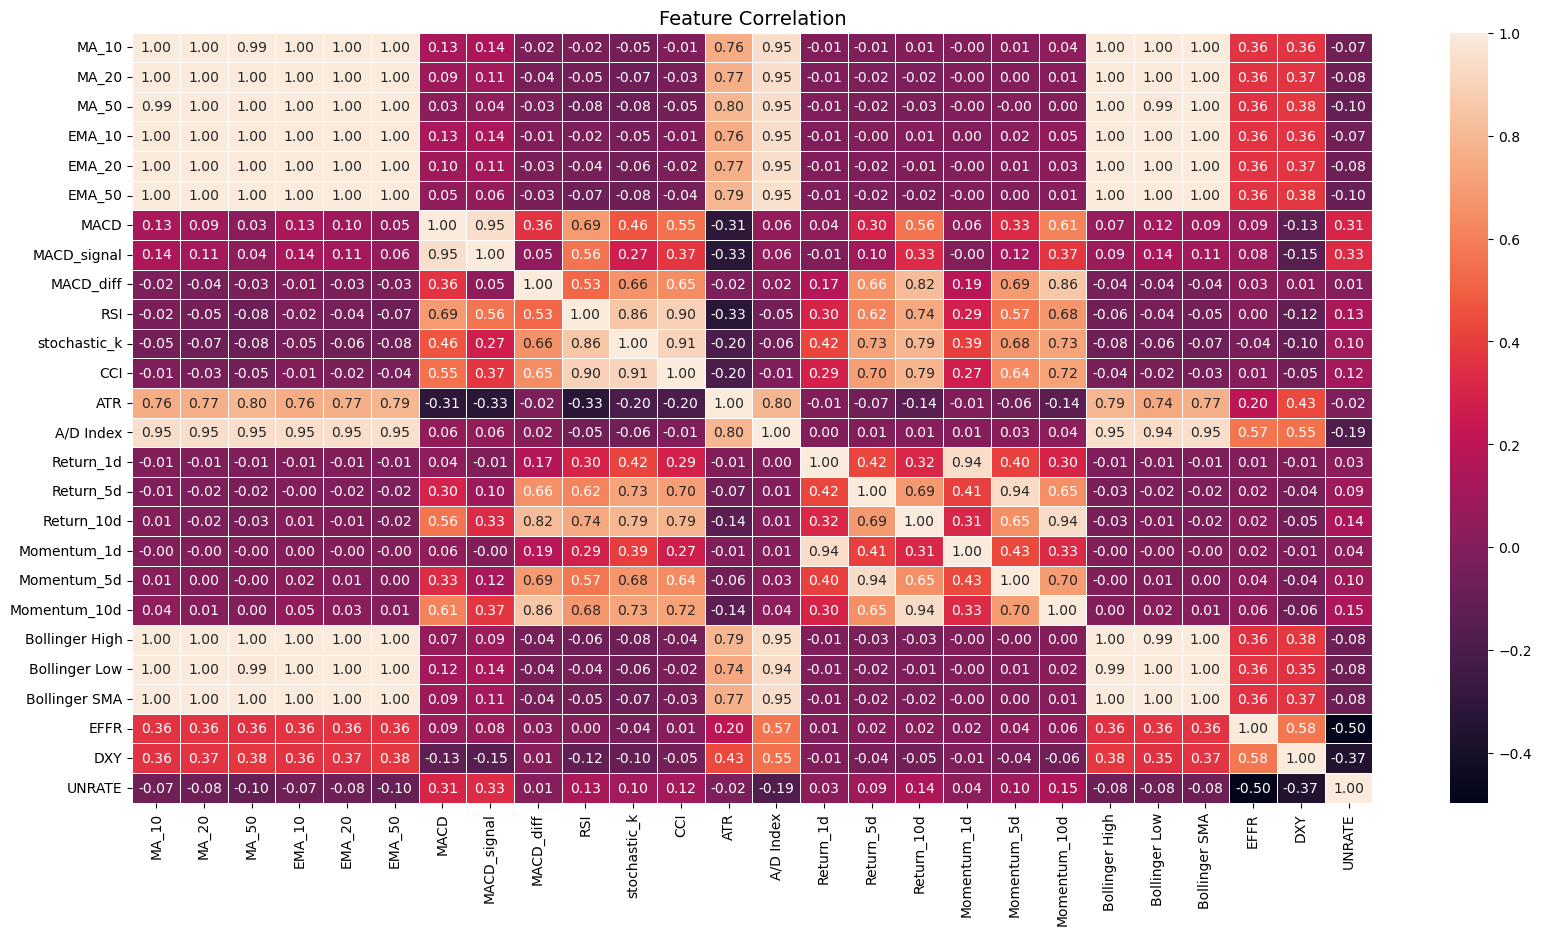

In [15]:

corrmat = XCMP_data_all_indicators.drop(['Adj Close', 'High','Low','Volume','Open','Target'], axis=1).corr()

# Visualize feature correlation with 'Target'
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, ax=ax)
ax.set_title('Feature Correlation', fontsize=14, color='black')
plt.show()

## Removal of Highly Correlated Features

In the dataset labeled `XCMP_data_all_indicators`, several columns were removed due to their high degree of correlation with other features in the data. Specifically, the columns `MA_20`, `MA_50`, `EMA_20`, and `EMA_50` were dropped. Here are the reasons for this action:

- **Reduction of Multicollinearity**: High correlation among these moving averages (both simple and exponential) can lead to multicollinearity, where multiple features provide redundant information. This redundancy can skew the performance of predictive models by giving undue weight to these correlated features.

- **Improvement of Model Performance**: By removing these highly correlated indicators, the model's generalization ability can improve, reducing the risk of overfitting to the noise within highly correlated data.

- **Simplification of the Model**: Fewer features mean a simpler model, which is easier to interpret and faster to train. Simplifying the model can help in identifying the most impactful indicators.

These steps are taken to ensure that the predictive model built on this dataset is robust, efficient, and not biased by redundant data, ultimately leading to more reliable forecasts.


In [16]:
XCMP_data_all_indicators = XCMP_data_all_indicators.drop(columns=['MA_20','MA_50','EMA_20','EMA_50','Bollinger Low','Bollinger High'])

In [17]:
def lstm_data_transform(x_data, y_data, num_steps):
    """
    Transforms the input time series data and one-hot encoded target data into sequences suitable for LSTM training.
    """
    num_samples = x_data.shape[0] - num_steps
    num_features = x_data.shape[1]
    x_shape = (num_samples, num_steps, num_features)

    x_array = np.zeros(x_shape)
    y_array = np.zeros((num_samples, y_data.shape[1]))

    for i in range(num_samples):
        x_array[i] = x_data.iloc[i:i+num_steps].values
        y_array[i] = y_data.iloc[i+num_steps-1].values  # Align the last timestep of X with the corresponding Y

    return x_array, y_array

### Data Splitting and Preparation

In this step, the dataset is split into training and testing sets, and the target variable is converted to a one-hot encoded format to facilitate model training and evaluation:

- **One-Hot Encoding**: Before splitting the data, the `Target` column, which contains categorical labels (-1, 0, 1), is converted into a one-hot encoded format. This conversion creates three new binary columns corresponding to each category, enabling the model to perform multi-class classification.

- **Data Splitting**: The training set, which contains 80% of the data, is used to train the model. The remaining 20% forms the testing set, which is used to evaluate the model's performance. The feature columns (`X`) are used as input, and the newly created one-hot encoded columns serve as the output (`y`) that the model aims to predict.

This approach ensures that the input to the model is appropriately formatted and that the target data aligns with the requirements of using categorical cross-entropy as the loss function during model training.
.


In [18]:
# Convert 'Target' to one-hot encoded format before splitting
y = pd.get_dummies(XCMP_data_all_indicators['Target'], columns=[-1, 0, 1])

# Drop the 'Target' column from the features
X = XCMP_data_all_indicators.drop(columns=['Target'])

# Assuming your data is sorted by date, calculate the split index for 80% training
train_size = int(len(X) * 0.8)

# Split data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Number of time steps to use for each input sequence
time_steps = 10

# Transform both training and testing data
X_train_transformed, y_train_transformed = lstm_data_transform(X_train, y_train, time_steps)
X_test_transformed, y_test_transformed = lstm_data_transform(X_test, y_test, time_steps)

num_features = X_train_transformed.shape[2]
num_classes = y_test_transformed.shape[1]

# Output the shapes to confirm
print("Transformed training features shape:", X_train_transformed.shape)
print("Transformed training target shape:", y_train_transformed.shape)
print("Transformed testing features shape:", X_test_transformed.shape)
print("Transformed testing target shape:", y_test_transformed.shape)


Transformed training features shape: (1963, 10, 25)
Transformed training target shape: (1963, 3)
Transformed testing features shape: (484, 10, 25)
Transformed testing target shape: (484, 3)


### Building the LSTM Model

This function, `build_lstm_model`, constructs and compiles an LSTM (Long Short-Term Memory) model for time series prediction. The function is tailored to work with preprocessed input data that has already been split into training sets and where the target values are one-hot encoded.

#### Key Components of the Function:
- **Model Architecture:** The architecture is dynamically constructed based on the specified parameters such as the number of layers and neurons per layer. This modular design supports easy modifications to adapt the model's depth and width, accommodating various complexities and capacities.
- **Dropout:** To help prevent overfitting, dropout layers are included in the model. These layers randomly omit a portion of neuron activations during the training process.
- **Compilation:** The model is compiled using a chosen optimizer and a specific loss function, `categorical_crossentropy`, which is suitable for multi-class classification problems.

#### Function Flexibility:
The function's structure is designed to facilitate fine-tuning and is highly configurable. Parameters such as the number of LSTM layers, the number of neurons in each layer, and the dropout rate are adjustable, allowing for extensive experimentation to optimize model performance. This flexibility ensures that the model configuration aligns well with the categorical nature of the target data.
et data.


In [19]:
def build_lstm_model(num_features, num_classes, time_steps, n_layers, n_neurons, dropout_rate=0.2, optimizer='adam', metrics=['accuracy']):
    """
    Constructs and compiles an LSTM model for time series prediction based on architecture parameters and training configuration.

    Args:
        num_features (int): Number of features in each input sample.
        num_classes (int): Number of target classes (dimensions of the one-hot encoded target data).
        time_steps (int): Number of past records to consider for predicting a future value.
        n_layers (int): Number of LSTM layers.
        n_neurons (list): List containing the number of neurons for each LSTM layer.
        dropout_rate (float): Dropout rate to prevent overfitting.
        optimizer (str): Optimizer for compiling the model.
        metrics (list): List of metrics to evaluate the model.

    Returns:
        keras.engine.sequential.Sequential: Compiled LSTM model.
    """

    # Building the LSTM model
    model = Sequential()
    model.add(Input(shape=(time_steps, num_features)))  # Explicitly defining the input layer
    for i in range(n_layers):
        return_sequences = True if i < n_layers - 1 else False
        model.add(LSTM(n_neurons[i], activation='tanh', return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification


    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

    return model


## Time Series Prediction with LSTM using Keras and TimeSeriesSplit

This script sets up a predictive model using LSTM (Long Short-Term Memory) networks in Keras, tailored for time series data. The model is configured to predict stock prices based on historical data. Here are the key components and steps involved in the setup:

### Model Configuration
- **LSTM Architecture**: The model consists of three LSTM layers, with each layer containing 50 neurons. A dropout rate of 0.2 is applied to prevent overfitting.
- **Optimization and Metrics**: The 'adam' optimizer is used for training, with 'accuracy' as the metric for evaluating model performance.

### Model Training with Cross-Validation
- **TimeSeriesSplit**: To ensure the integrity of the temporal data sequence, `TimeSeriesSplit` from Scikit-learn is used. This method is particularly suited for time series data, as it respects the chronological order of the data, avoiding leakage between training and validation phases.
- **Training Process**: The model is trained and validated across 5 different sequential splits to ensure robustness and generalizability. This helps in understanding the model's performance across different time segments of the dataset.

### Results
- The scores from each validation fold are recorded and the average score is computed to provide a holistic view of the model's performance.

This setup provides a robust framework for developing and evaluating time series prediction models, ensuring that the temporal sequence and characteristics of the data are appropriately managed.


In [20]:
# Parameters
n_layers = 3  # Number of LSTM Layers
n_neurons = [50, 50, 50]  # Number of neurons in each layer
dropout_rate = 0.2  # Dropout rate to prevent overfitting
optimizer = 'adam'  # Optimizer for the model
metrics = ['accuracy']  # Metrics to evaluate the model
n_splits = 5  # Number of splits for cross-validation
epochs = 50  # Number of epochs to train the model
batch_size = 32  # Batch size for training

model = build_lstm_model(num_features=num_features, 
                         num_classes=num_classes,
                         time_steps=time_steps,
                         n_layers=n_layers,
                         n_neurons=n_neurons,
                         dropout_rate=dropout_rate,
                         optimizer=optimizer,
                         metrics=metrics
                        )

history = model.fit(X_train_transformed, y_train_transformed,epochs = epochs, batch_size=batch_size)

    


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.4532 - loss: 1.0561
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5089 - loss: 1.0190
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5204 - loss: 1.0172
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5309 - loss: 0.9982
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5105 - loss: 0.9982
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5114 - loss: 0.9872
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5327 - loss: 0.9641
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6689 - loss: 0.7345
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8566 - loss: 0.3734
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8925 - loss: 0.2774
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9032 - loss: 0.2412
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy